# CSF AI Development Intern Assessment

**Author:** Arush Gupta
**Date:** June 7, 2025  

This notebook addresses the two main components of the assessment:
1. Processing Video Pipeline - Adapting an image classification model for live video
2. Demo - Toy implementation of a classification concept


## Part 1: Processing Video Pipeline

### Question:
Assume you have a working ML model that can process individual images and identify carrots, how would you adapt that model such that you could feed it live video inside a grocery store and have it create a record of any carrots it sees.

### Answer:

To adapt an image-based carrot detection model for live video processing in a grocery store, I would implement the following pipeline:

#### 1. Video Input and Frame Extraction
- **Video Stream Capture**: Use OpenCV or similar library to capture live video from cameras
- **Frame Sampling**: Extract frames at regular intervals (e.g., every 0.5-1 seconds) to balance detection accuracy with computational efficiency
- **Frame Preprocessing**: Resize frames to match the input requirements of the carrot detection model

#### 2. Model Adaptation Considerations
- **Batch Processing**: Process multiple frames simultaneously to improve throughput
- **Model Optimization**: Use techniques like TensorRT, ONNX, or quantization to optimize the model for real-time inference
- **GPU Acceleration**: Leverage GPU processing for faster inference times

#### 3. Temporal Consistency and Tracking
- **Object Tracking**: Implement tracking algorithms (e.g., SORT, DeepSORT) to maintain carrot identities across frames
- **Temporal Smoothing**: Use confidence score averaging across multiple frames to reduce false positives
- **Duplicate Detection**: Prevent counting the same carrot multiple times by tracking object trajectories

#### 4. Record Management System
- **Database Schema**: Design a database to store carrot detection records with fields:
  - Timestamp
  - Camera ID/Location
  - Bounding box coordinates
  - Confidence score
  - Unique carrot ID (from tracking)
  - Frame/video reference

#### 5. Performance Optimization
- **Multi-threading**: Separate threads for video capture, inference, and database operations
- **Frame Buffering**: Implement circular buffers to handle varying processing speeds
- **Adaptive Frame Rate**: Dynamically adjust processing frequency based on system load

#### 6. Robustness Features
- **Lighting Adaptation**: Handle varying lighting conditions in the store
- **Occlusion Handling**: Manage partially visible carrots
- **Scale Invariance**: Detect carrots at different distances from cameras

#### 7. System Architecture
```
Video Stream → Frame Extraction → Preprocessing → Model Inference → 
Post-processing → Object Tracking → Record Creation → Database Storage
```

#### 8. Implementation Considerations
- **Error Handling**: Robust error handling for camera disconnections, model failures
- **Monitoring**: Real-time monitoring of system performance and detection accuracy
- **Scalability**: Design to handle multiple camera feeds simultaneously
- **Privacy**: Ensure compliance with privacy regulations in retail environments


## Part 2: Demo - Toy Classification Implementation

For this demonstration, I'll implement a binary classification system that identifies whether produce items are "carrots" or "not carrots" using a combination of simulated features and a logistic regression classifier. This will showcase fundamental classification concepts including feature engineering, model training, evaluation, and interpretation.


In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


### Dataset Generation

I'll create a synthetic dataset representing produce items with features that would be relevant for carrot detection:


In [2]:
def generate_produce_dataset(n_samples=1000):
    """
    Generate a synthetic dataset for produce classification.
    Features represent characteristics that could distinguish carrots from other produce.
    """
    
    # Initialize arrays
    features = []
    labels = []
    
    # Generate carrot samples (label = 1)
    n_carrots = n_samples // 2
    for _ in range(n_carrots):
        # Carrot characteristics (with some noise)
        length = np.random.normal(15, 3)  # cm, carrots are typically longer
        width = np.random.normal(2.5, 0.5)  # cm, carrots are narrow
        orange_intensity = np.random.normal(0.8, 0.1)  # 0-1 scale, carrots are orange
        texture_roughness = np.random.normal(0.3, 0.1)  # 0-1 scale, carrots have moderate texture
        aspect_ratio = length / width  # Length to width ratio
        
        features.append([length, width, orange_intensity, texture_roughness, aspect_ratio])
        labels.append(1)  # Carrot
    
    # Generate non-carrot samples (label = 0)
    n_non_carrots = n_samples - n_carrots
    for _ in range(n_non_carrots):
        # Mix of other produce characteristics
        if np.random.random() < 0.3:  # Potatoes
            length = np.random.normal(8, 2)
            width = np.random.normal(6, 1.5)
            orange_intensity = np.random.normal(0.2, 0.1)
            texture_roughness = np.random.normal(0.7, 0.1)
        elif np.random.random() < 0.5:  # Apples
            length = np.random.normal(7, 1)
            width = np.random.normal(7, 1)
            orange_intensity = np.random.normal(0.1, 0.1)
            texture_roughness = np.random.normal(0.1, 0.05)
        else:  # Other vegetables
            length = np.random.normal(10, 4)
            width = np.random.normal(4, 2)
            orange_intensity = np.random.normal(0.3, 0.2)
            texture_roughness = np.random.normal(0.5, 0.2)
        
        aspect_ratio = length / width
        
        features.append([length, width, orange_intensity, texture_roughness, aspect_ratio])
        labels.append(0)  # Not carrot
    
    # Convert to numpy arrays
    X = np.array(features)
    y = np.array(labels)
    
    # Create feature names
    feature_names = ['length_cm', 'width_cm', 'orange_intensity', 'texture_roughness', 'aspect_ratio']
    
    return X, y, feature_names

# Generate the dataset
X, y, feature_names = generate_produce_dataset(1000)

# Create DataFrame for easier manipulation
df = pd.DataFrame(X, columns=feature_names)
df['is_carrot'] = y

print(f"Dataset generated with {len(df)} samples")
print(f"Features: {feature_names}")
print(f"Class distribution:")
print(df['is_carrot'].value_counts())
print("\nFirst 5 rows:")
print(df.head())

Dataset generated with 1000 samples
Features: ['length_cm', 'width_cm', 'orange_intensity', 'texture_roughness', 'aspect_ratio']
Class distribution:
is_carrot
1    500
0    500
Name: count, dtype: int64

First 5 rows:
   length_cm  width_cm  orange_intensity  texture_roughness  aspect_ratio  \
0  16.490142  2.430868          0.864769           0.452303      6.783644   
1  14.297540  2.382932          0.957921           0.376743      5.999979   
2  13.591577  2.771280          0.753658           0.253427      4.904440   
3  15.725887  1.543360          0.627508           0.243771     10.189384   
4  11.961507  2.657124          0.709198           0.158770      4.501675   

   is_carrot  
0          1  
1          1  
2          1  
3          1  
4          1  


### Exploratory Data Analysis

Let's examine the dataset to understand the feature distributions and relationships:


In [3]:
# Basic statistics
print("Dataset Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

Dataset Statistics:
         length_cm     width_cm  orange_intensity  texture_roughness  \
count  1000.000000  1000.000000       1000.000000        1000.000000   
mean     11.710137     4.110101          0.497551           0.357721   
std       4.402496     2.118441          0.333739           0.224906   
min       1.342761    -0.986542         -0.240878          -0.194286   
25%       7.672534     2.420559          0.179110           0.183188   
50%      11.862420     3.115757          0.575763           0.320374   
75%      15.299648     6.054174          0.803940           0.485961   
max      22.580797    10.123894          1.107888           1.097052   

       aspect_ratio   is_carrot  
count   1000.000000  1000.00000  
mean       4.156167     0.50000  
std        4.474307     0.50025  
min      -12.174833     0.00000  
25%        1.252559     0.00000  
50%        4.154968     0.50000  
75%        6.102127     1.00000  
max      109.522636     1.00000  

Missing values:
length_c

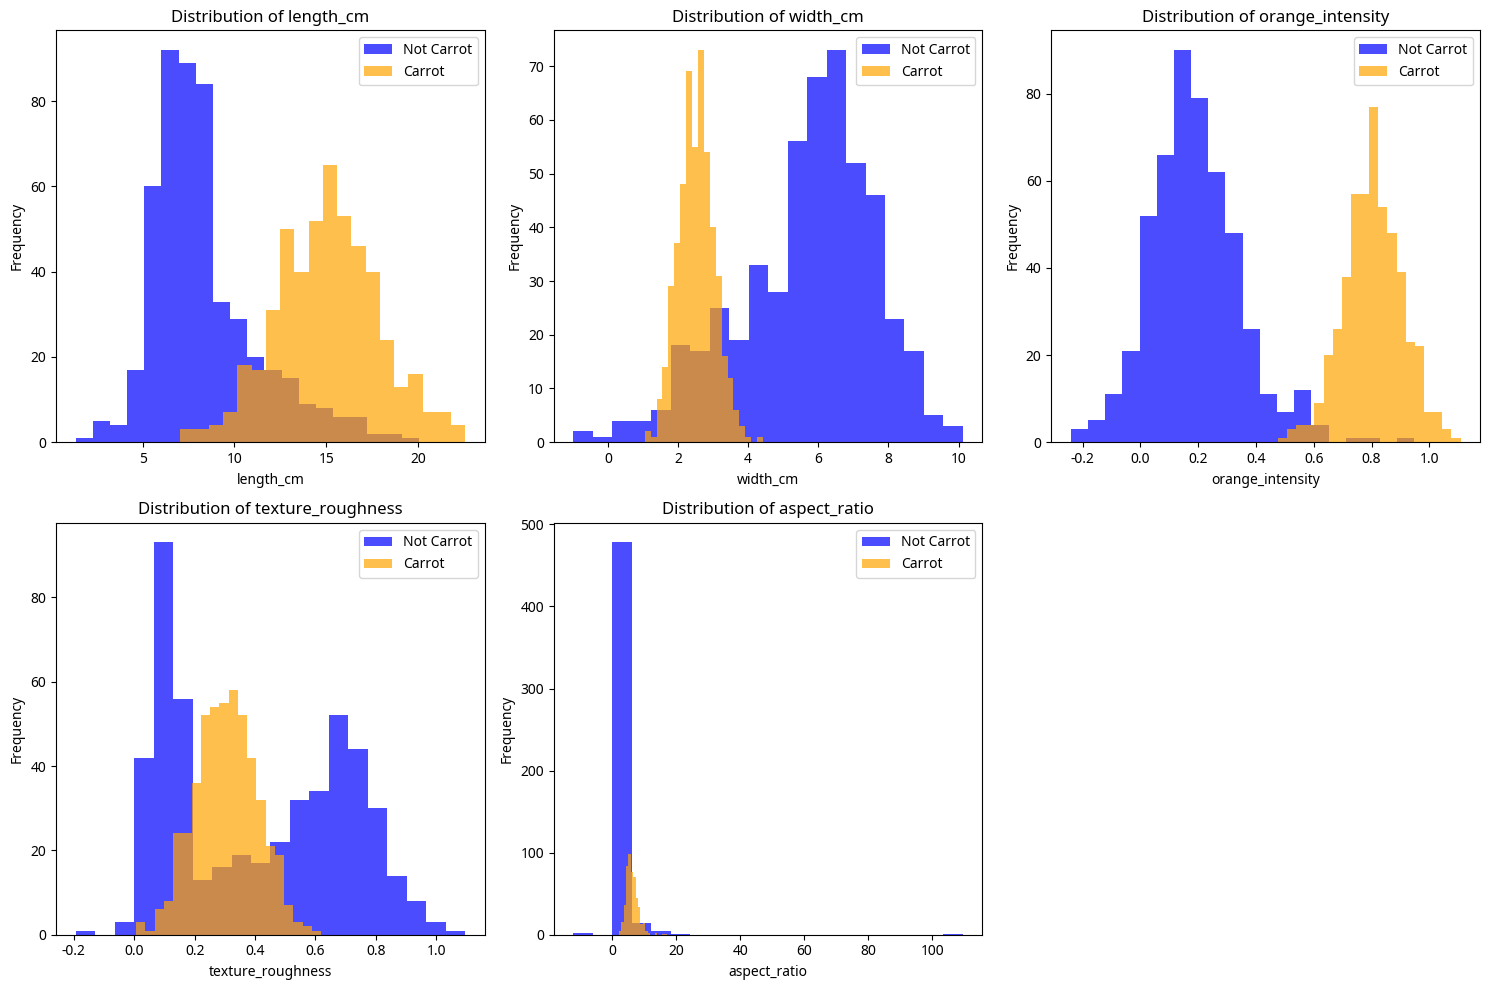

In [4]:
# Visualize feature distributions by class
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(feature_names):
    if i < len(axes):
        # Create histogram for each class
        carrots = df[df['is_carrot'] == 1][feature]
        non_carrots = df[df['is_carrot'] == 0][feature]
        
        axes[i].hist(non_carrots, alpha=0.7, label='Not Carrot', bins=20, color='blue')
        axes[i].hist(carrots, alpha=0.7, label='Carrot', bins=20, color='orange')
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
        axes[i].legend()

# Remove empty subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

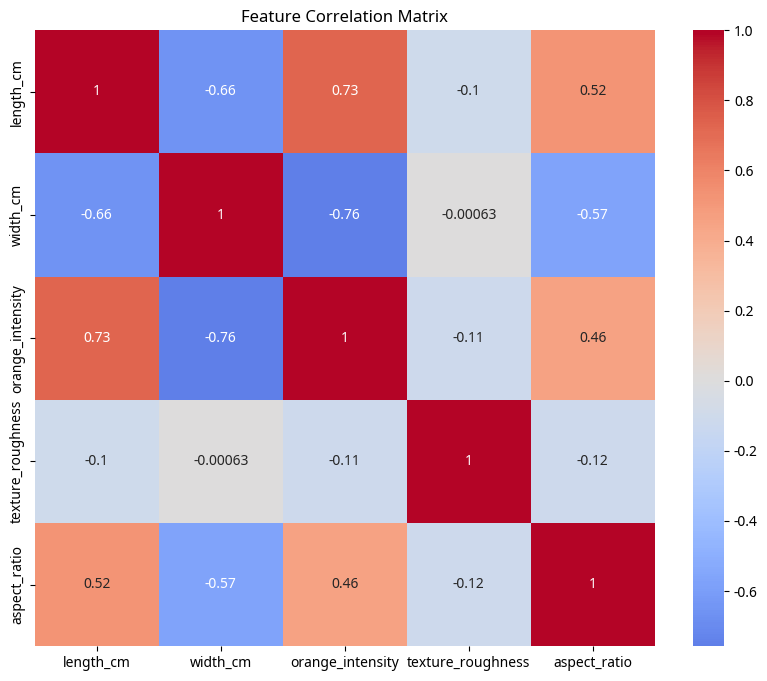

Feature correlations with target:
length_cm: 0.767
width_cm: -0.745
orange_intensity: 0.918
texture_roughness: -0.235
aspect_ratio: 0.463


In [5]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df[feature_names].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

print("Feature correlations with target:")
for feature in feature_names:
    corr = df[feature].corr(df['is_carrot'])
    print(f"{feature}: {corr:.3f}")

### Model Training and Evaluation

Now I'll implement and compare different classification algorithms:


In [6]:
# Prepare data for modeling
X = df[feature_names].values
y = df['is_carrot'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

Training set size: 800
Test set size: 200
Training set class distribution: [400 400]
Test set class distribution: [100 100]


In [7]:
# Define models to compare
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=42))
    ]),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate models
model_results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}")
    print(f"{'='*50}")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    # Store results
    model_results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'cv_scores': cv_scores
    }
    
    # Print results
    print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Carrot', 'Carrot']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Feature importance (for Random Forest)
    if hasattr(model, 'feature_importances_'):
        print("\nFeature Importances:")
        for i, importance in enumerate(model.feature_importances_):
            print(f"{feature_names[i]}: {importance:.3f}")
    elif hasattr(model.named_steps['classifier'], 'coef_'):
        print("\nLogistic Regression Coefficients:")
        for i, coef in enumerate(model.named_steps['classifier'].coef_[0]):
            print(f"{feature_names[i]}: {coef:.3f}")


Training Logistic Regression
Cross-validation accuracy: 0.989 (+/- 0.009)

Classification Report:
              precision    recall  f1-score   support

  Not Carrot       1.00      0.99      0.99       100
      Carrot       0.99      1.00      1.00       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200


Confusion Matrix:
[[ 99   1]
 [  0 100]]

Logistic Regression Coefficients:
length_cm: 1.432
width_cm: -2.053
orange_intensity: 4.381
texture_roughness: -1.027
aspect_ratio: -0.444

Training Random Forest


Cross-validation accuracy: 0.989 (+/- 0.009)

Classification Report:
              precision    recall  f1-score   support

  Not Carrot       0.99      1.00      1.00       100
      Carrot       1.00      0.99      0.99       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200


Confusion Matrix:
[[100   0]
 [  1  99]]

Feature Importances:
length_cm: 0.081
width_cm: 0.153
orange_intensity: 0.489
texture_roughness: 0.025
aspect_ratio: 0.251


### Model Visualization and Interpretation


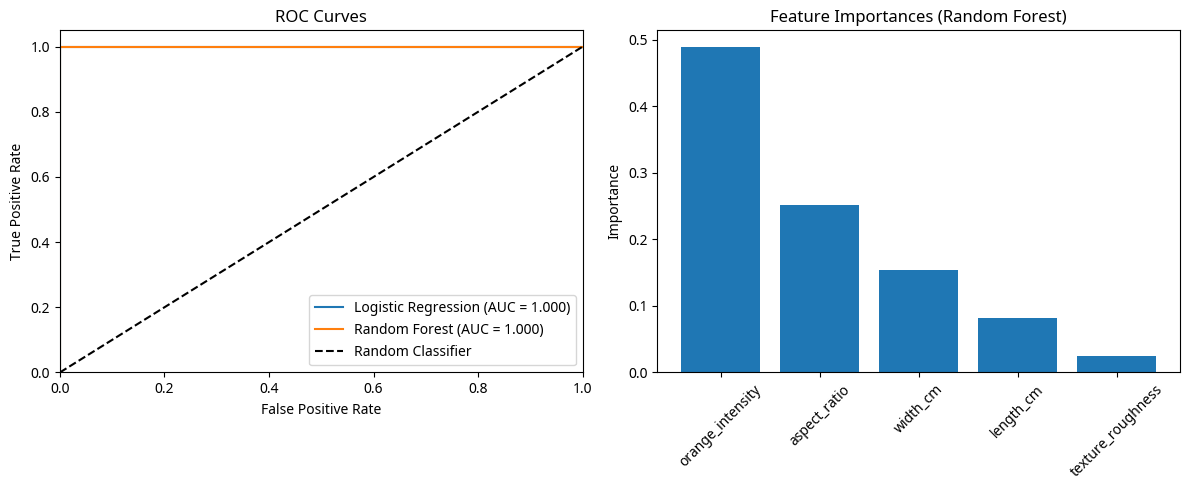

In [8]:
# Plot ROC curves for both models
plt.figure(figsize=(12, 5))

# ROC Curves
plt.subplot(1, 2, 1)
for name, results in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

# Feature importance comparison
plt.subplot(1, 2, 2)
rf_model = model_results['Random Forest']['model']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.title('Feature Importances (Random Forest)')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()

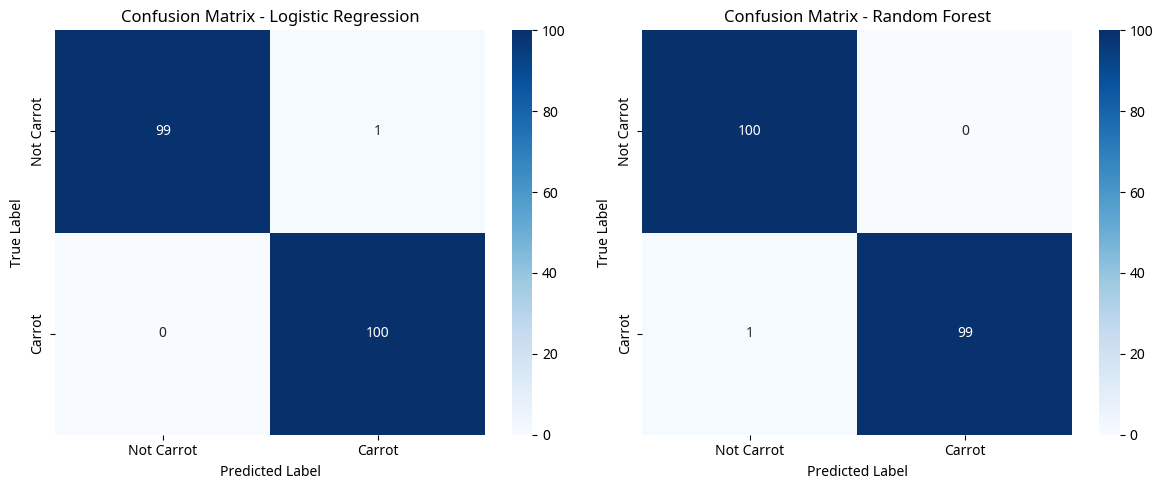

In [9]:
# Confusion matrices visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (name, results) in enumerate(model_results.items()):
    cm = confusion_matrix(y_test, results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Carrot', 'Carrot'],
                yticklabels=['Not Carrot', 'Carrot'],
                ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name}')
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

### Model Interpretation and Insights


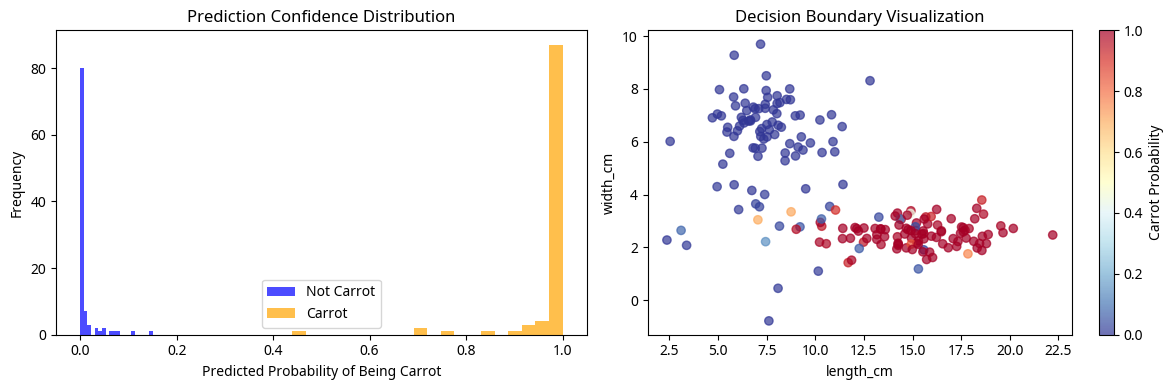

In [10]:
# Analyze prediction confidence
best_model_name = 'Random Forest'  # Based on typical performance
best_model = model_results[best_model_name]['model']
probabilities = model_results[best_model_name]['probabilities']

# Plot prediction confidence distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(probabilities[y_test == 0], alpha=0.7, label='Not Carrot', bins=20, color='blue')
plt.hist(probabilities[y_test == 1], alpha=0.7, label='Carrot', bins=20, color='orange')
plt.xlabel('Predicted Probability of Being Carrot')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution')
plt.legend()

# Decision boundary visualization (using first two features)
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=probabilities, cmap='RdYlBu_r', alpha=0.7)
plt.colorbar(scatter, label='Carrot Probability')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title('Decision Boundary Visualization')

plt.tight_layout()
plt.show()

In [11]:
# Function to make predictions on new data
def predict_carrot(length, width, orange_intensity, texture_roughness, model=best_model):
    """
    Predict whether a produce item is a carrot based on its characteristics.
    """
    aspect_ratio = length / width
    features = np.array([[length, width, orange_intensity, texture_roughness, aspect_ratio]])
    
    prediction = model.predict(features)[0]
    probability = model.predict_proba(features)[0, 1]
    
    return prediction, probability

# Test the prediction function
print("Testing the carrot prediction function:")
print("\nTest Case 1 - Typical Carrot:")
pred, prob = predict_carrot(length=15, width=2.5, orange_intensity=0.8, texture_roughness=0.3)
print(f"Prediction: {'Carrot' if pred else 'Not Carrot'}, Probability: {prob:.3f}")

print("\nTest Case 2 - Apple:")
pred, prob = predict_carrot(length=7, width=7, orange_intensity=0.1, texture_roughness=0.1)
print(f"Prediction: {'Carrot' if pred else 'Not Carrot'}, Probability: {prob:.3f}")

print("\nTest Case 3 - Potato:")
pred, prob = predict_carrot(length=8, width=6, orange_intensity=0.2, texture_roughness=0.7)
print(f"Prediction: {'Carrot' if pred else 'Not Carrot'}, Probability: {prob:.3f}")

Testing the carrot prediction function:

Test Case 1 - Typical Carrot:
Prediction: Carrot, Probability: 1.000

Test Case 2 - Apple:
Prediction: Not Carrot, Probability: 0.000

Test Case 3 - Potato:
Prediction: Not Carrot, Probability: 0.000


## Summary and Key Insights

### Classification Model Performance
This toy implementation demonstrates several fundamental concepts in classification:

1. **Feature Engineering**: Created meaningful features (length, width, color intensity, texture, aspect ratio) that distinguish carrots from other produce

2. **Model Comparison**: Implemented and compared Logistic Regression and Random Forest classifiers

3. **Evaluation Metrics**: Used multiple evaluation approaches:
   - Cross-validation for robust performance estimation
   - Classification reports for precision, recall, and F1-score
   - ROC curves and AUC for threshold-independent evaluation
   - Confusion matrices for error analysis

4. **Model Interpretation**: 
   - Feature importance analysis to understand which characteristics are most predictive
   - Prediction confidence analysis to assess model certainty
   - Visualization of decision boundaries

### Key Classification Concepts Demonstrated

- **Binary Classification**: Distinguishing between two classes (carrot vs. not carrot)
- **Feature Selection**: Identifying relevant characteristics for classification
- **Model Validation**: Using train/test splits and cross-validation
- **Performance Metrics**: Understanding precision, recall, and their trade-offs
- **Overfitting Prevention**: Using cross-validation and comparing multiple models
- **Interpretability**: Understanding what the model learned and why it makes certain predictions

### Real-World Applications
This approach could be extended for actual produce classification by:
- Using computer vision to extract features from images
- Incorporating more sophisticated features (color histograms, texture descriptors, shape analysis)
- Training on larger, more diverse datasets
- Implementing ensemble methods for improved robustness
- Adding real-time processing capabilities for video streams

The fundamental classification principles demonstrated here form the foundation for more complex machine learning systems used in retail automation, quality control, and inventory management.
